In [149]:
import sagemaker
import boto3

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [150]:
!aws s3 cp s3://raw-olist-ecommerce/olist_data/ ./Data/ --recursive --exclude "*" --include "*.csv"

download: s3://raw-olist-ecommerce/olist_data/product_category_name_translation.csv to Data/product_category_name_translation.csv
download: s3://raw-olist-ecommerce/olist_data/order_payments_dataset.csv to Data/order_payments_dataset.csv
download: s3://raw-olist-ecommerce/olist_data/customers_dataset.csv to Data/customers_dataset.csv
download: s3://raw-olist-ecommerce/olist_data/sellers_dataset.csv to Data/sellers_dataset.csv
download: s3://raw-olist-ecommerce/olist_data/products_dataset.csv to Data/products_dataset.csv
download: s3://raw-olist-ecommerce/olist_data/order_reviews_dataset.csv to Data/order_reviews_dataset.csv
download: s3://raw-olist-ecommerce/olist_data/order_items_dataset.csv to Data/order_items_dataset.csv
download: s3://raw-olist-ecommerce/olist_data/orders_dataset.csv to Data/orders_dataset.csv
download: s3://raw-olist-ecommerce/olist_data/geolocation_dataset.csv to Data/geolocation_dataset.csv


In [151]:
import pandas as pd
from pyathena import connect
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



In [152]:
# set check for creating athena DB
create_athena_db_passed = False
# set db name
database_name = "ads_508_team_5"

In [153]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [154]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)

CREATE DATABASE IF NOT EXISTS ads_508_team_5


In [155]:
pd.read_sql(statement, conn)

""


In [156]:
statement = "SHOW DATABASES"

db_show = pd.read_sql(statement, conn)
db_show.head(5)

,database_name
0,ads_508_team_5
1,default


In [157]:
if database_name in db_show.values:
    ingest_create_athena_db_passed = True

In [158]:
# create a Boto3 client for Athena
athena_client = boto3.client("athena", region_name = region)
# Bring down the database name again 
database_name = "ads_508_team_5"
# create my S3 path to the whole bucket 
s3_path_olist = "s3://raw-olist-ecommerce/olist_data/"


In [159]:
## Manuel create all teh table for Athena
customer_table_statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.customers_table(
    customer_id string,
          customer_unique_id string,
          customer_zip_code_prefix int,
          customer_city string,
          customer_state string
          )
          ROW FORMAT DELIMITED
          FIELDS TERMINATED BY ','
          STORED AS TEXTFILE
          LOCATION 's3://raw-olist-ecommerce/customers_data/'
          TBLPROPERTIES ("skip.header.line.count"="1");""".format(database_name)

geolocation_table_statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.geolocation_table(
          geolocation_zip_code_prefix int,
          geolocation_lat double,
          geolocation_lng double,
          geolocation_city string,
          geolocation_state string
          )
          ROW FORMAT DELIMITED
          FIELDS TERMINATED BY ','
          STORED AS TEXTFILE
          LOCATION 's3://raw-olist-ecommerce/geolocation_dataset/'
          TBLPROPERTIES ("skip.header.line.count"="1");""".format(database_name)

order_items_table_statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.order_items_table(
          order_id string,
          order_item_id int,
          product_id string,
          seller_id string,
          shipping_limit_date timestamp,
          price double,
          freight_value double
          )
          ROW FORMAT DELIMITED
          FIELDS TERMINATED BY ','
          STORED AS TEXTFILE
          LOCATION 's3://raw-olist-ecommerce/order_items_data/'
          TBLPROPERTIES ("skip.header.line.count"="1");""".format(database_name)

order_reviews_table_statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.order_reviews_table(
          review_id string,
          order_id string,
          review_score int,
          review_comment_message string,
          review_creation_date timestamp,
          review_answer_timestamp timestamp
          )
          ROW FORMAT DELIMITED
          FIELDS TERMINATED BY ','
          STORED AS TEXTFILE
          LOCATION 's3://raw-olist-ecommerce/order_reviews_data/'
          TBLPROPERTIES ("skip.header.line.count"="1");""".format(database_name)

orders_table_statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.orders_table(
          order_id string,
          customer_id string,
          order_status string,
          order_purchase_timestamp timestamp,
          order_approved_at timestamp,
          order_delivered_carrier_date timestamp,
          order_delivered_customer_date timestamp,
          order_estimated_delivery_date timestamp
          )
          ROW FORMAT DELIMITED
          FIELDS TERMINATED BY ','
          STORED AS TEXTFILE
          LOCATION 's3://raw-olist-ecommerce/orders_data/'
          TBLPROPERTIES ("skip.header.line.count"="1");""".format(database_name)

order_payments_statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.order_payments_table(
          order_id string,
          payment_sequential int,
          payment_type string,
          payment_installments int,
          payment_value double
          )
          ROW FORMAT DELIMITED
          FIELDS TERMINATED BY ','
          STORED AS TEXTFILE
          LOCATION 's3://raw-olist-ecommerce/prder_payments_data/'
          TBLPROPERTIES ("skip.header.line.count"="1");""".format(database_name)


product_category_statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.product_category_table(
          product_category_name string,
          product_category_name_english string
          )
          ROW FORMAT DELIMITED
          FIELDS TERMINATED BY ','
          STORED AS TEXTFILE
          LOCATION 's3://raw-olist-ecommerce/product_cat_name_data/'
          TBLPROPERTIES ("skip.header.line.count"="1");""".format(database_name)

products_statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.product_table(
          product_category_name string,
          product_category_name_english string
          )
          ROW FORMAT DELIMITED
          FIELDS TERMINATED BY ','
          STORED AS TEXTFILE
          LOCATION 's3://raw-olist-ecommerce/products_data/'
          TBLPROPERTIES ("skip.header.line.count"="1");""".format(database_name)

sellers_statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.sellers_table(
          seller_id string,
          seller_zip_code_prefix int,
          seller_city string,
          seller_state string
          )
          ROW FORMAT DELIMITED
          FIELDS TERMINATED BY ','
          STORED AS TEXTFILE
          LOCATION 's3://raw-olist-ecommerce/sellers_data/'
          TBLPROPERTIES ("skip.header.line.count"="1");""".format(database_name)

In [160]:
write_cust_table = pd.read_sql(customer_table_statement, conn)
write_geo_table = pd.read_sql(geolocation_table_statement, conn)
write_order_items_table = pd.read_sql(order_items_table_statement, conn)
write_order_reviews_table = pd.read_sql(order_reviews_table_statement, conn)
write_orders_table = pd.read_sql(orders_table_statement, conn)
write_order_payments_table = pd.read_sql(order_payments_statement, conn)
write_prod_cat_table = pd.read_sql(product_category_statement, conn)
write_product_table = pd.read_sql(products_statement, conn)
write_seller_table = pd.read_sql(sellers_statement, conn)

In [162]:
query1 = """select * from ads_508_team_5.customers_table limit 5;"""
df_show = pd.read_sql(query1,conn) 
df_show

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,"""06b8999e2fba1a1fbc88172c00ba8bc7""","""861eff4711a542e4b93843c6dd7febb0""",None,franca,SP
1,"""18955e83d337fd6b2def6b18a428ac77""","""290c77bc529b7ac935b93aa66c333dc3""",None,sao bernardo do campo,SP
2,"""4e7b3e00288586ebd08712fdd0374a03""","""060e732b5b29e8181a18229c7b0b2b5e""",None,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,"""259dac757896d24d7702b9acbbff3f3c""",None,mogi das cruzes,SP
4,"""4f2d8ab171c80ec8364f7c12e35b23ad""","""345ecd01c38d18a9036ed96c73b8d066""",None,campinas,SP


In [90]:
query1 = """select * from ads_508_team_5.customers_table limit 5;"""
df_show = pd.read_sql(query1,conn) 
df_show

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,"""06b8999e2fba1a1fbc88172c00ba8bc7""","""861eff4711a542e4b93843c6dd7febb0""",None,franca,SP
1,"""18955e83d337fd6b2def6b18a428ac77""","""290c77bc529b7ac935b93aa66c333dc3""",None,sao bernardo do campo,SP
2,"""4e7b3e00288586ebd08712fdd0374a03""","""060e732b5b29e8181a18229c7b0b2b5e""",None,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,"""259dac757896d24d7702b9acbbff3f3c""",None,mogi das cruzes,SP
4,"""4f2d8ab171c80ec8364f7c12e35b23ad""","""345ecd01c38d18a9036ed96c73b8d066""",None,campinas,SP


In [91]:
query1 = """ SELECT 
    order_status, 
    COUNT(*) as total_orders 
FROM ads_508_team_5.orders_table 
GROUP BY order_status; """
df = pd.read_sql(query1,conn) 
df

,order_status,total_orders
0,invoiced,314
1,shipped,1107
2,unavailable,609
3,created,5
4,delivered,96478
5,processing,301
6,canceled,625
7,approved,2


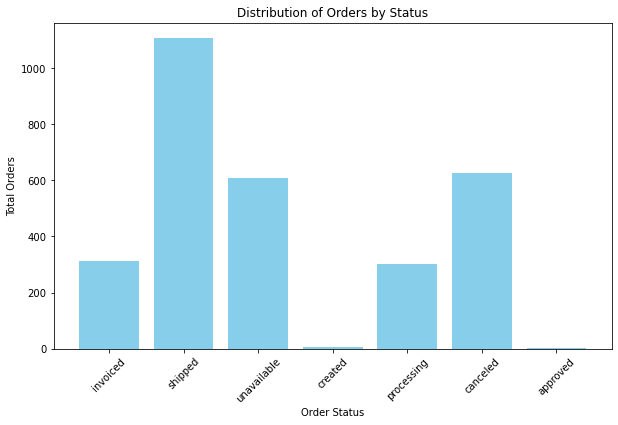

In [32]:

# Why delivery is not executing properly 

df = df[df['order_status'] != 'delivered']

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(df['order_status'], df['total_orders'], color='skyblue')
plt.xlabel('Order Status')
plt.ylabel('Total Orders')
plt.title('Distribution of Orders by Status')
plt.xticks(rotation=45)
plt.show()


In [92]:
query1 = """
SELECT 
    AVG(date_diff('day', order_purchase_timestamp, order_delivered_customer_date)) as avg_delivery_time 
FROM ads_508_team_5.orders_table
WHERE order_status = 'delivered';
"""
average_delivery_time = pd.read_sql(query1,conn) 
average_delivery_time

,avg_delivery_time
0,12.093604


In [93]:
# customer per state 
query1 = """ 
SELECT 
    c.customer_state, 
    COUNT(DISTINCT o.customer_id) as customer_count,
    AVG(date_diff('day', o.order_purchase_timestamp, o.order_delivered_customer_date)) as avg_delivery_time 
FROM ads_508_team_5.orders_table o 
JOIN ads_508_team_5.customers_table c ON o.customer_id = c.customer_id 
WHERE o.order_status = 'delivered'
GROUP BY c.customer_state
ORDER BY customer_count DESC;
"""
#HAVING COUNT(DISTINCT o.customer_id) >= 100 

df = pd.read_sql(query1,conn) 
df.head()

,customer_state,customer_count,avg_delivery_time
0,SP,40501,8.298094
1,RJ,12350,14.848583
2,MG,11354,11.542188
3,RS,5345,14.819237
4,PR,4923,11.526711


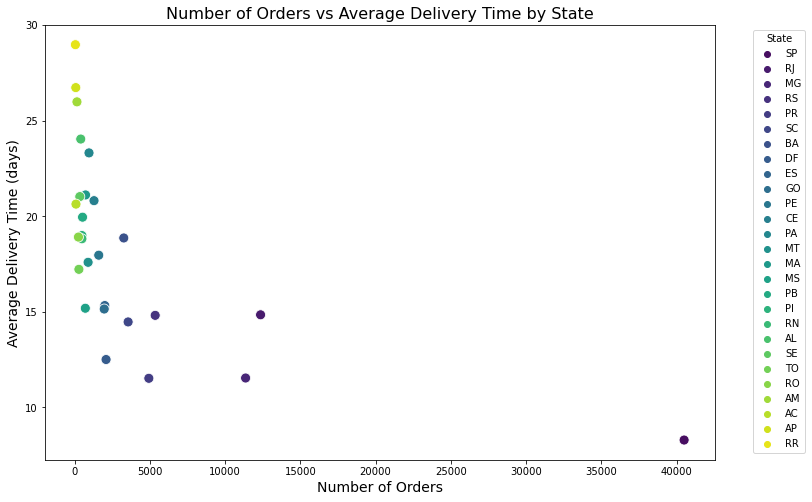

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is your existing DataFrame
# Update these lines if your DataFrame has different names for these columns
states = df["customer_state"]
num_orders = df["customer_count"] 
avg_delivery_time = df["avg_delivery_time"] 

# Update the DataFrame to use the correct column names
df = pd.DataFrame({'State': states, 'Number of Orders': num_orders, 'Average Delivery Time': avg_delivery_time})

# Creating the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Number of Orders', y='Average Delivery Time', hue='State', s=100, palette='viridis')

# Adding labels and title
plt.xlabel('Number of Orders', fontsize=14)
plt.ylabel('Average Delivery Time (days)', fontsize=14)
plt.title('Number of Orders vs Average Delivery Time by State', fontsize=16)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')

# Showing the plot
plt.show()


So, if the number of order increases then the average delivery time is decreased. 

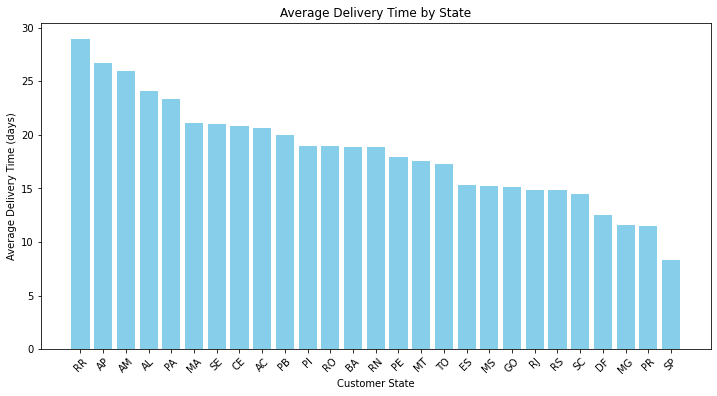

In [95]:
query1 = """SELECT 
    c.customer_state, 
    AVG(date_diff('day', o.order_purchase_timestamp, o.order_delivered_customer_date)) as avg_delivery_time 
FROM ads_508_team_5.orders_table o 
JOIN ads_508_team_5.customers_table c ON o.customer_id = c.customer_id 
WHERE o.order_status = 'delivered'
GROUP BY c.customer_state
ORDER BY avg_delivery_time DESC;
 """

df = pd.read_sql(query1,conn) 

# Creating the bar plot
plt.figure(figsize=(12, 6))
plt.bar(df['customer_state'], df['avg_delivery_time'], color='skyblue')
plt.xlabel('Customer State')
plt.ylabel('Average Delivery Time (days)')
plt.title('Average Delivery Time by State')
plt.xticks(rotation=45)
plt.show()

### Frequency of Delayed Orders:

`Purpose:` Determine how often orders are delivered later than the estimated delivery date.



In [96]:
query1 = """SELECT 
    COUNT(*) as delayed_orders 
FROM ads_508_team_5.orders_table
WHERE order_estimated_delivery_date < order_delivered_customer_date;
""" 
df = pd.read_sql(query1,conn) 
df.head()


,delayed_orders
0,7827


### Analysis of Freight Value:

`Purpose:` Explore the range and average of freight values, which might impact delivery times.



In [135]:
query1 = """SELECT 
    c.customer_state, 
    COUNT(DISTINCT o.customer_id) as customer_count,
    AVG(date_diff('day', o.order_purchase_timestamp, o.order_delivered_customer_date)) as avg_delivery_time,
    AVG(oi.freight_value) as avg_freight, 
    MAX(oi.freight_value) as max_freight, 
    MIN(oi.freight_value) as min_freight
FROM ads_508_team_5.orders_table o 
JOIN ads_508_team_5.customers_table c ON o.customer_id = c.customer_id
JOIN ads_508_team_5.order_items_table oi ON o.order_id = oi.order_id
WHERE o.order_status = 'delivered'
GROUP BY c.customer_state
ORDER BY customer_count DESC;
"""

df = pd.read_sql(query1,conn) 
df.head()


,customer_state,customer_count,avg_delivery_time,avg_freight,max_freight,min_freight
0,SP,40501,8.259663,15.115182,339.59,0.0
1,RJ,12350,14.688821,20.911436,207.78,0.0
2,MG,11354,11.514091,20.626343,322.10,0.0
3,RS,5345,14.708299,21.613192,254.55,0.0
4,PR,4923,11.480793,20.471816,375.28,0.0


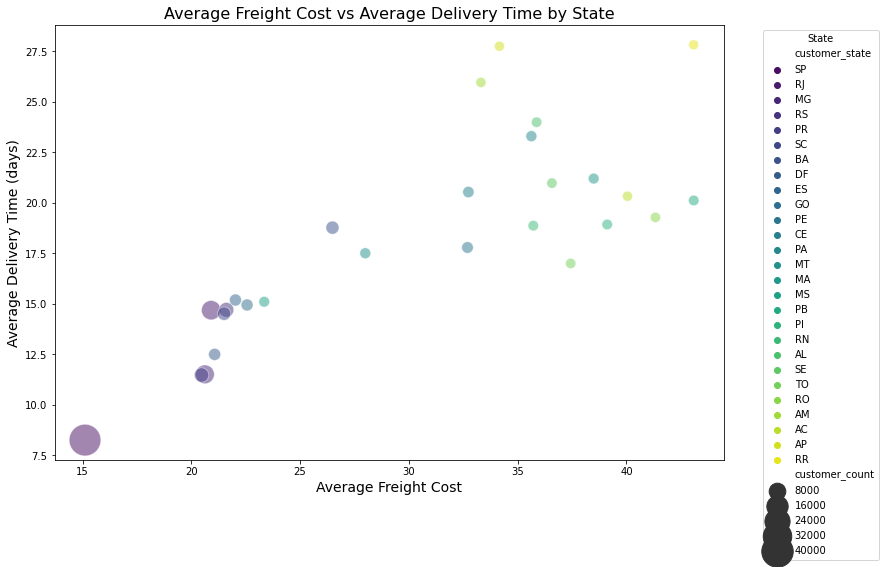

In [137]:
# Creating the scatter plot with bubble sizes
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='avg_freight', y='avg_delivery_time', size='customer_count', 
                hue='customer_state', sizes=(100, 1000), alpha=0.5, palette='viridis')

plt.xlabel('Average Freight Cost', fontsize=14)
plt.ylabel('Average Delivery Time (days)', fontsize=14)
plt.title('Average Freight Cost vs Average Delivery Time by State', fontsize=16)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

### Review Scores and Delivery Time:

`Purpose:` Investigate if there's a relationship between delivery times and customer satisfaction (review scores).



In [142]:
query1 = """SELECT 
    c.customer_state, 
    COUNT(DISTINCT o.customer_id) as customer_count,
    AVG(date_diff('day', o.order_purchase_timestamp, o.order_delivered_customer_date)) as avg_delivery_time,
    AVG(oi.freight_value) as avg_freight, 
    MAX(oi.freight_value) as max_freight, 
    AVG(r.review_score) as avg_review_score
FROM ads_508_team_5.orders_table o 
JOIN ads_508_team_5.customers_table c ON o.customer_id = c.customer_id
JOIN ads_508_team_5.order_items_table oi ON o.order_id = oi.order_id
JOIN ads_508_team_5.order_reviews_table r ON o.order_id = r.order_id
WHERE o.order_status = 'delivered'
GROUP BY c.customer_state
ORDER BY customer_count DESC;
"""
df = pd.read_sql(query1,conn) 
df.head()

,customer_state,customer_count,avg_delivery_time,avg_freight,max_freight,avg_review_score
0,SP,40501,8.264783,15.111222,339.59,4.164801
1,RJ,12350,14.697694,20.903872,207.78,3.851026
2,MG,11354,11.516506,20.609331,322.10,4.106887
3,RS,5345,14.719508,21.586900,254.55,4.087983
4,PR,4923,11.489688,20.483659,375.28,4.134144


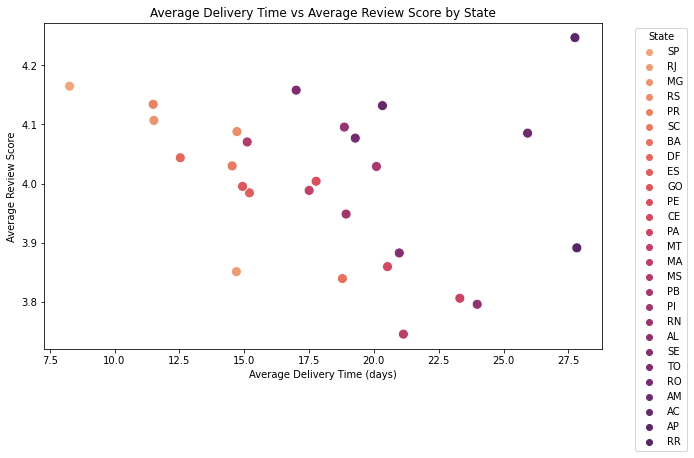

In [147]:
# Creating the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='avg_delivery_time', y='avg_review_score', hue='customer_state', palette='flare', s=100)

# Adding labels and title
plt.xlabel('Average Delivery Time (days)')
plt.ylabel('Average Review Score')
plt.title('Average Delivery Time vs Average Review Score by State')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')


# Showing the plot
plt.show()